# 04: Create monetization perspectives

In this script, we first preprocess the collection of monetization factors. We then create a Monte Carlo sample from all factors, and then select the factors for the single approach perspectives.

In [16]:
%run common_definitions.py
%run plotting_functions.py

In [2]:
import pandas as pd
import xarray as xr
import numpy as np

import brightway2 as bw

import yaml

## Define impact categories

In [3]:
simple_categories = [
    "climate change",
    "acidification",
    "particulate matter formation",
    "ozone depletion",
    "ionizing radiation",
    "fossil resources",
    "metal/mineral resources",
    "water use"
]

categories_w_subcategories = [
    "human toxicity",
    "eutrophication",
    "ecotoxicity",
    "photochemical oxidant formation",
    "land use"
]

all_categories = simple_categories + categories_w_subcategories

In [4]:
def draw_mvcs_from_method(df, size, distribution_type="triangular"):
    """
    Draw 
    """
    df.set_index("estimate", inplace=True)
    if set(df.index) == {"central"}:
        return np.ones(size) * df.loc["central"]["MVC"]
    elif set(df.index) == {"min", "max"}:
        low = df.loc["min"]["MVC"]
        high = df.loc["max"]["MVC"]
        if distribution_type == "triangular":
            return np.random.triangular(low, (high+low)/2, high, size)
    elif set(df.index) == {"central", "min", "max"}:
        low = df.loc["min"]["MVC"]
        high = df.loc["max"]["MVC"]
        mode = df.loc["central"]["MVC"]
        if distribution_type == "triangular":
            return np.random.triangular(low, mode, high, size)
    else: # treat as individual samples
        a = np.array(df["MVC"])
        return np.random.choice(a, size)

    
def get_missing_subcategories(df, impact_category):
    """
    Get missing impact subcategories for a given method.
    """
    given_subcats = set(df["impact category"].unique())
    if given_subcats == {impact_category}:
        return []
    else: # THIS IS A WORKAROUND FOR NOW; NOT GUARANTEED TO STAY MEANINGFUL WITH NEW DATA
        if impact_category == "eutrophication":
            if given_subcats == {"eutrophication: freshwater"}:
                return ["eutrophication: marine"]
            else:
                return []
        elif impact_category == "photochemical oxidant formation":
            if given_subcats == {"photochemical oxidant formation: human health"}:
                return ["photochemical oxidant formation: terrestrial ecosystems"]
            else:
                return []
        elif impact_category == "ecotoxicity":
            if given_subcats == {"ecotoxicity: freshwater"}:
                return ["ecotoxicity: marine", "ecotoxicity: terrestrial"]
            elif given_subcats == {"ecotoxicity: marine"}:
                return ["ecotoxicity: freshwater", "ecotoxicity: terrestrial"]
            else:
                return []
        else:
            return []
            
def complement_method(mdf, df, impact_category):
    missing = get_missing_subcategories(mdf, impact_category)
    approach = list(mdf["valuation approach"].unique())

    given_subcats = list(mdf["impact category"].unique())
    flist = [mdf[mdf["impact category"] == sc] for sc in given_subcats]
    for ic in missing:
        sel = df[df["impact category"] == ic]
        options = list(sel["source name"].unique())
        if len(approach) == 1 and isinstance(approach[0], str):
            same_approach = sel[sel["valuation approach"] == approach[0]]
            if len(same_approach) > 0:
                options = list(same_approach["source name"].unique())
            
        choice = np.random.choice(options, 1)[0]
        flist.append(sel[sel["source name"] == choice])

    return flist

def draw_monetization_sample(df_mvc, impact_category, size, distribution_type="triangular"):
    """
    Draw a random sample of monetization methods for a given impact category.

    :param df: dataframe containing the monetary valuation coefficients.
    :param impact_category: impact category for which to draw.
    :param size: size of the sample
    :return: list of dictionaries of LCIA method: mvc
    """
    df = df_mvc[df_mvc["impact category"].str.startswith(impact_category)]

    # if no subcategories
    if impact_category in simple_categories:
        options = df["source name"].unique()
        choices = np.random.choice(options, size)
        uniques, counts = np.unique(choices, return_counts=True)
        sample = []
        for m, s in zip(uniques, counts):
            method_df = df[df["source name"] == m]
            lcia = method_df.iloc[0]["LCIA method"]
            sample += [{lcia: mvc} for mvc in draw_mvcs_from_method(method_df, s,
                                                                    distribution_type=distribution_type)]
        return sample
    
    else:
        options = df["source name"].unique()
        initial_choices = np.random.choice(options, size)
        method_frames = []
        for choice in initial_choices:
            mdf = df[df["source name"] == choice]
            method_frames.append(complement_method(mdf, df, impact_category))
        sample = []
        for flist in method_frames:
            mvc_dict = {}
            for frame in flist:
                lcia = frame.iloc[0]["LCIA method"]
                mvc = draw_mvcs_from_method(frame, 1, distribution_type=distribution_type)
                if lcia in mvc_dict.keys():
                    mvc_dict[lcia] += mvc
                else:
                    mvc_dict[lcia] = mvc    
            sample.append(mvc_dict)
        return sample
    
def convert_sample_to_matrix(sample, methods):
    mvc_matrix = np.zeros(((len(sample)), len(methods)))
    name2index = dict(zip(methods, range(len(methods))))
    for i, mdict in enumerate(sample):
        for lcia, mvc in mdict.items():
            mvc_matrix[i][name2index[lcia]] = mvc
    
    return mvc_matrix

def generate_full_sample(mvc_data, cpi_data, size,
                         distribution_type="triangular", exclude_list=None, target_year=2022):
    """
    Generate a sample of MCVs for all impact categories.
    """
    # read data file of MVCs
    df = pd.read_csv(mvc_data)

    # filter out MVCs without a matching LCIA method
    df.dropna(subset="LCIA method", inplace=True)

    # exclude some sources
    all_sources = list(df["source name"].unique())
    if exclude_list:
        include_list = list(set(all_sources)-set(exclude_list))
        df = df[df["source name"].isin(include_list)]

    # get all needed methods
    methods = list(df["LCIA method"].unique())

    # load consumer price index data, transform MVCs to EUR2023
    HICP = pd.read_csv(cpi_data).set_index("year")
    HICP = HICP["average HICP"]
    df["conversion factor"] = df["reference year"].apply(lambda x: HICP[target_year] / HICP[x])
    df["MVC"] = df["MVC"] * df["conversion factor"]

    # generate samples
    samples = []
    for ic in all_categories:
        sample = draw_monetization_sample(df, ic, size, distribution_type=distribution_type)
        samples.append(convert_sample_to_matrix(sample, methods))

    da = xr.DataArray(
        np.array(samples),
        {
            "impact category": all_categories,
            "sample index": np.arange(size),
            "LCIA method": methods
        }
    )

    return da

There are Environmental Prices for EU27 and Netherlands, we only keep the former ones.

In [5]:
exclude_list = ["Environmental prices, 2023, Netherlands"]

All monetization factors in the collection are already in euros, so we just need to convert to the target year.

In [7]:
mvc_sample = generate_full_sample("../data/mfs_all_factors.csv",
                                  "../data/HICPdata.csv",
                                  MC_SAMPLE_SIZE,
                                  exclude_list=exclude_list,
                                  target_year=EURO_REF_YEAR)

In [8]:
mvc_sample.to_netcdf("../data/mfs_monte_carlo_sample_euro{}.nc".format(str(EURO_REF_YEAR)))

Generate a larger sample for the sensitivity analysis:

In [6]:
mvc_sample_larger = generate_full_sample("../data/mfs_all_factors.csv",
                                  "../data/HICPdata.csv",
                                  MC_SAMPLE_SIZE_LARGER,
                                  exclude_list=exclude_list,
                                  target_year=EURO_REF_YEAR)

mvc_sample_larger.to_netcdf("../data/mfs_monte_carlo_sample_euro{}_larger.nc".format(str(EURO_REF_YEAR)))

In [7]:
mvc_sample_larger

<xarray.DataArray (impact category: 13, sample index: 20000, LCIA method: 70)>
array([[[0.21555612, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.04380573, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.22807137, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.11704294, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.11704294, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.11704294, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]])
Coordinates:
  * impact category  (impact category) <U31 'climate change' ... 'land use'
  * sample index     (sample index) int32 0 1 2 3 4 ... 19996 19997 19998 19999
  * LCIA method      (LCIA method) <U150 'IPCC 2021, climate change, GWP 100a...

In [8]:
import matplotlib.pyplot as plt

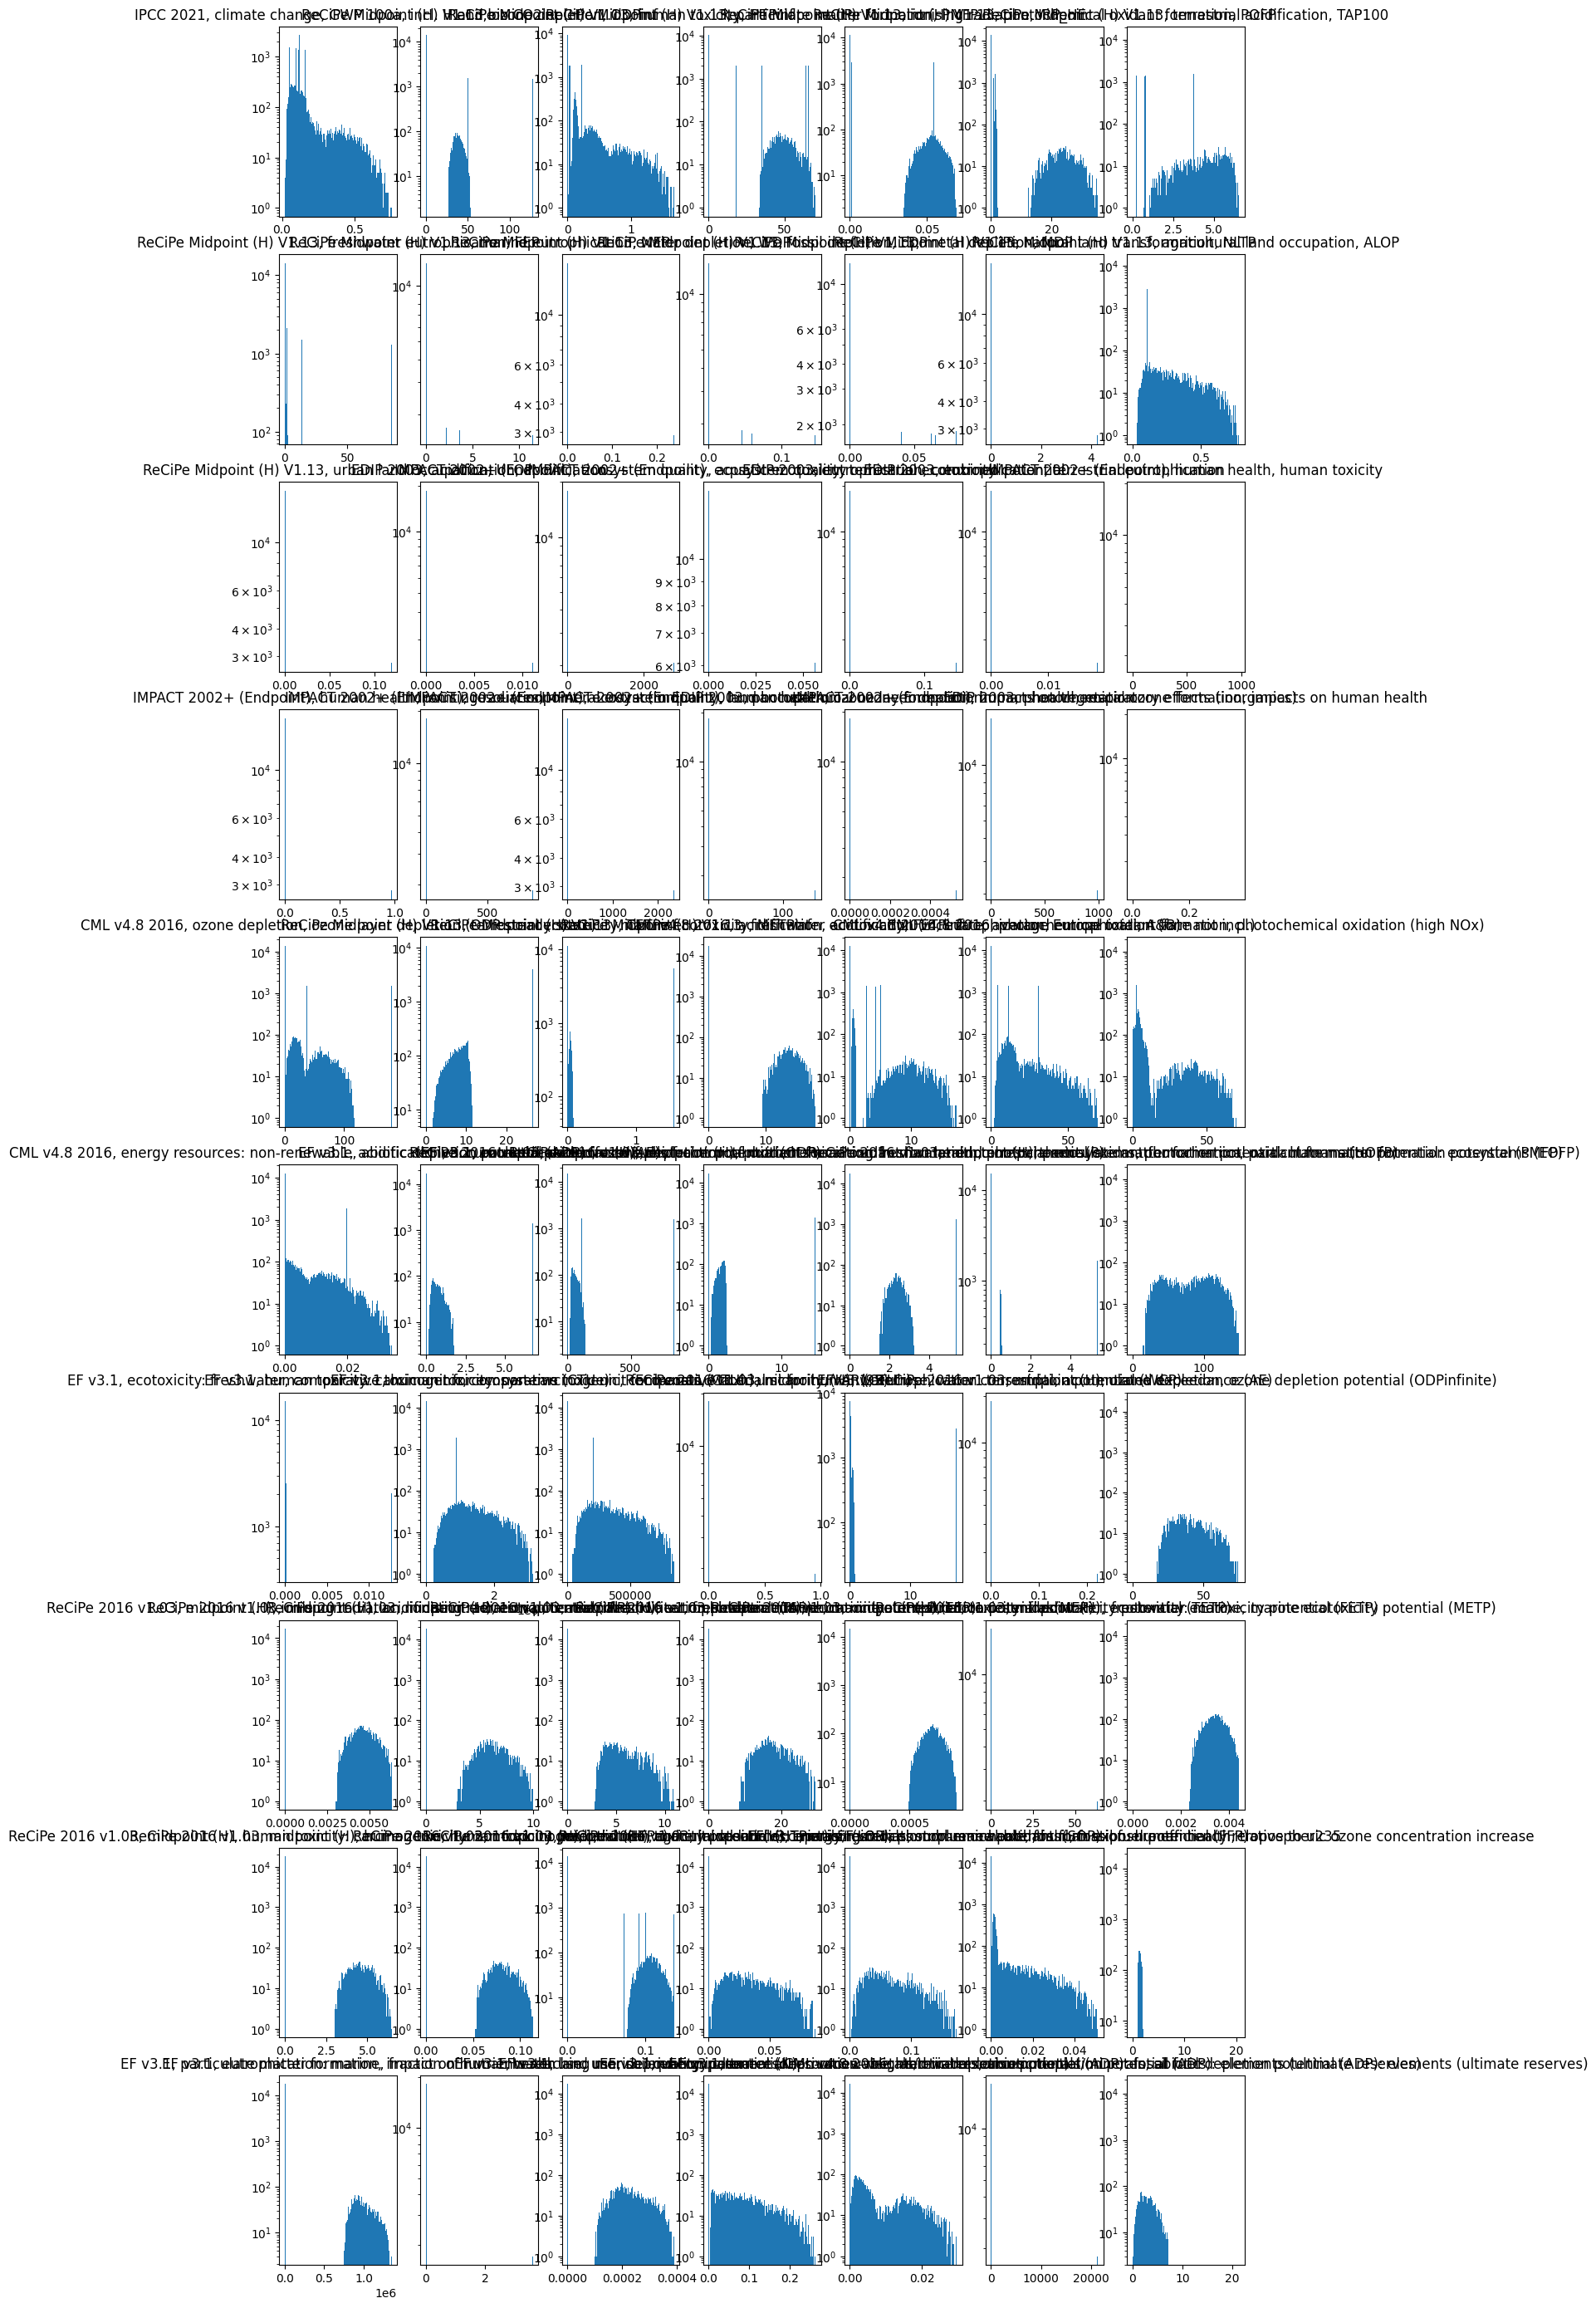

In [12]:
fig, axs = plt.subplots(10, 7, figsize=(15, 35))

for ax, m in zip(axs.flat, list(mvc_sample_larger.coords["LCIA method"].values)):
    ax.set_title(m)
    y = mvc_sample_larger.sel({"LCIA method": m}).sum(dim="impact category")
    ax.hist(y, bins=150)

    ax.set_yscale("log")

fig.savefig("mvc_sample_distributions.pdf")

## Extend the sample to include climate change methods by sources

In [9]:
CCmethods = [", ".join(m) for m in [
    ("IPCC 2021", "climate change: biogenic", "GWP 100a"),
    ("IPCC 2021", "climate change: land use", "GWP 100a"),
    ("IPCC 2021", "climate change: fossil", "GWP 100a")
]]

In [10]:
toadd = xr.DataArray(
    np.zeros((mvc_sample.shape[0], mvc_sample.shape[1], 3)),
    coords={
        "impact category": list(mvc_sample.coords["impact category"].values),
        "sample index": list(mvc_sample.coords["sample index"].values),
        "LCIA method": CCmethods
    }
)
mvc_enlarged = xr.concat((mvc_sample, toadd), dim="LCIA method")

In [11]:
cc_mvcs = mvc_enlarged.sel({
    "impact category": "climate change",
    "LCIA method": "IPCC 2021, climate change, GWP 100a, incl. H and bio CO2"
}).to_numpy()

vals2add = np.zeros((3, mvc_enlarged.shape[1], mvc_enlarged.shape[2]))
vals2add[0,:,-3] = cc_mvcs
vals2add[1,:,-2] = cc_mvcs
vals2add[2,:,-1] = cc_mvcs

toadd2 = xr.DataArray(
    vals2add,
    coords={
        "impact category": [m.split(", ")[1] for m in CCmethods],
        "sample index": list(mvc_enlarged.coords["sample index"].values),
        "LCIA method": list(mvc_enlarged.coords["LCIA method"].values)
    }
)
mvc_sample_cc = xr.concat((mvc_enlarged, toadd2), dim="impact category")

In [12]:
mvc_sample_cc.to_netcdf("../data/mfs_monte_carlo_sample_extended_euro{}.nc".format(str(EURO_REF_YEAR)))

## Create monetization perspectives by approaches

First load all monetization factors

In [5]:
df = pd.read_csv("../data/mfs_all_factors.csv").dropna(subset="LCIA method")

Add central values where only minimum and maximum exists; for this, take the average of minimum and maximum.

In [6]:
all_sources = list(df["source name"].unique())
rows_to_add = []

for source in all_sources:
    sel = df[df["source name"] == source]
    for ic in list(sel["impact category"].unique()):
        mdf = sel[sel["impact category"] == ic]
        estimates = set(mdf["estimate"])
        if estimates == {"min", "max"}:
            new_row = mdf.iloc[0].copy()
            new_row.loc["MVC"] = mdf["MVC"].mean()
            new_row.loc["estimate"] = "central"
            rows_to_add.append(new_row)

df = pd.concat([df, pd.DataFrame(rows_to_add)])

Adjust currency values to target year.

In [7]:
HICP = pd.read_csv("../data/HICPdata.csv").set_index("year")
HICP = HICP["average HICP"]

df["conversion factor"] = df["reference year"].apply(lambda x: HICP[EURO_REF_YEAR] / HICP[x])
df["MVC"] = df["MVC"] * df["conversion factor"]
df["reference year"] = EURO_REF_YEAR

Get the mapping between perspectives and monetization factors

In [8]:
perspectives_dict = yaml.safe_load(open("../mappings/perspectives.yml", "r"))

Finally, obtain "vectors" of monetization factors, i.e. per perspective monetization factors for each LCIA method used in this project.

In [17]:
df.set_index(["source name", "impact category", "estimate"], inplace=True)
idx_list = []
samples = []

for perspective in perspectives_dict:
    for ic, mlist in perspectives_dict[perspective].items():
        if mlist is None:
            print("{} missing for perspective {}".format(ic, perspective))
        else:
            idx_list.append((perspective, ic))
            sample = {}
            for m in mlist:
                k = df.loc[tuple(m.values())]["LCIA method"]
                v = df.loc[tuple(m.values())]["MVC"]
                sample[k] = v
            samples.append(sample)

df.reset_index(inplace=True)

df_perspectives = pd.DataFrame(
    samples,
    index=pd.MultiIndex.from_tuples(idx_list, names=["perspective", "impact category"]),
)
df_perspectives.to_csv("../data/mfs_perspectives_euro_{}.csv".format(str(EURO_REF_YEAR)))

fossil resources missing for perspective damage costs
metal/mineral resources missing for perspective damage costs
fossil resources missing for perspective prevention costs
ionizing radiation missing for perspective prevention costs
fossil resources missing for perspective budget constraint
water use missing for perspective budget constraint
ionizing radiation missing for perspective taxation costs
land use missing for perspective taxation costs
metal/mineral resources missing for perspective taxation costs
particulate matter formation missing for perspective taxation costs
water use missing for perspective taxation costs


Extend with climate change LCIA methods by sources

In [18]:
MFs = df_perspectives.copy().fillna(0)

df_perspectives.reset_index(inplace=True)

mfs_perspectives = MFs.melt(
    var_name="LCIA method", ignore_index=False).reset_index().set_index(
        ["perspective", "impact category", "LCIA method"])["value"].to_xarray().fillna(0)

In [19]:
mfs_perspectives

<xarray.DataArray 'value' (perspective: 4, impact category: 13, LCIA method: 45)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 2.71985496,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.04575922, 26.64120229],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]])
Coordinates:
  * perspective      (perspective) object 'budget constraint' ... 'taxation c...
  * impact category  (impact category) object 'acidification' ... 'water use'
  * LCIA method      (LCIA method) object 'CML v4.8 2016, acidification, acid...

In [20]:
needed_methods = list(mvc_sample_cc.coords["LCIA method"].values)

In [21]:
methods2add = list(set(needed_methods) - set(MFs.columns))

toadd = xr.DataArray(
    np.zeros((mfs_perspectives.shape[0], mfs_perspectives.shape[1], len(methods2add))),
    coords={
        "perspective": list(mfs_perspectives.coords["perspective"].values),
        "impact category": list(mfs_perspectives.coords["impact category"].values),
        "LCIA method": methods2add
    }
)
mfs_enlarged = xr.concat((mfs_perspectives, toadd), dim="LCIA method")

In [22]:
cc_mvcs = mfs_enlarged.sel({
    "impact category": "climate change",
    "LCIA method": "IPCC 2021, climate change, GWP 100a, incl. H and bio CO2"
}).to_numpy()

toadd2 = xr.DataArray(
    np.zeros((mfs_enlarged.shape[0], 3, mfs_enlarged.shape[2])),
    coords={
        "perspective": list(mfs_enlarged.coords["perspective"].values),
        "impact category": [m.split(", ")[1] for m in CCmethods],
        "LCIA method": list(mfs_enlarged.coords["LCIA method"].values)
    }
)

for m in CCmethods:
    toadd2.loc[:,m.split(", ")[1],m] = cc_mvcs

mfs_perspectives_cc = xr.concat((mfs_enlarged, toadd2), dim="impact category")

In [23]:
mfs_perspectives_cc.to_netcdf("../data/mfs_perspectives_extended_euro_{}.nc".format(EURO_REF_YEAR))

### Obtain the number of studies in the collection

In [3]:
df = pd.read_csv("../data/mfs_all_factors.csv").dropna(subset="LCIA method")

exclude_list = ["Environmental prices, 2023, Netherlands"]
all_sources = list(df["source name"].unique())
include_list = list(set(all_sources)-set(exclude_list))

if TAKE_OUT_FOSSIL_RESOURCES_MIDPOINT:
    df = df[df["impact category"] != "fossil resources"]

In [4]:
df_all_included = df[df["source name"].isin(include_list)]
df_all_included

,source name,impact category,estimate,LCIA method,valuation approach,MVC,currency,reference year,impact unit
0,Alberici et al. (2014),climate change,central,"IPCC 2021, climate change, GWP 100a, incl. H a...",damage cost,0.0430,Euro,2012,kg CO2 eq
1,Alberici et al. (2014),ozone depletion,central,"ReCiPe Midpoint (H) V1.13, ozone depletion, OD...",damage cost,107.0000,Euro,2012,kg CFC-11 eq
2,Alberici et al. (2014),human toxicity,central,"ReCiPe Midpoint (H) V1.13, human toxicity, HTPinf",damage cost,0.0400,Euro,2012,kg 1-4 DB eq
3,Alberici et al. (2014),particulate matter formation,central,"ReCiPe Midpoint (H) V1.13, particulate matter ...",damage cost,15.0000,Euro,2012,kg PM10 eq
4,Alberici et al. (2014),ionizing radiation,central,"ReCiPe Midpoint (H) V1.13, ionising radiation,...",damage cost,0.0010,Euro,2012,kBq U235 eq
...,...,...,...,...,...,...,...,...,...
362,Cao et al 2015,land use,Brazil,"ReCiPe 2016 v1.03, midpoint (H), land use, agr...",abatement cost,0.0621,Euro,2015,m2*a crop Eq
363,Cao et al 2015,land use,Italy,"ReCiPe 2016 v1.03, midpoint (H), land use, agr...",abatement cost,0.0790,Euro,2015,m2*a crop Eq
364,Cao et al 2015,land use,US,"ReCiPe 2016 v1.03, midpoint (H), land use, agr...",abatement cost,0.1170,Euro,2015,m2*a crop Eq
365,"Ligthart et al, abatement",water use,central,"ReCiPe 2016 v1.03, midpoint (H), water use, wa...",abatement cost,15.8000,Euro,2019,m3


In [5]:
len(df_all_included["source name"].unique())

22

Number of monetization factors or distributions of monetization factors.

In [6]:
len(df_all_included.groupby(["source name", "impact category"]).count())

160

### Create mean costs as a brightway method

For this, we use the original climate change LCIA method, not the ones distinguished by sources.

In [99]:
bw.projects.set_current(BW_PROJECTNAME)

In [100]:
mfs_mc_sample = xr.open_dataarray("../data/mfs_monte_carlo_sample_euro{}_larger.nc".format(str(EURO_REF_YEAR)))

In [101]:
mean_mfs_by_category = mfs_mc_sample.mean(dim="sample index")

In [102]:
def sum_up_CFs(CFlist):
    keys = [CF[0] for CF in CFlist]
    values = [CF[1] for CF in CFlist]
    df = pd.DataFrame({"keys": keys, "values": values})
    summed = df.groupby("keys").sum()
    return [[k, v] for k, v in zip(summed.index, summed["values"])]

In [103]:
for ic in list(mean_mfs_by_category.coords["impact category"].values):
    MFs = mean_mfs_by_category.sel({"impact category": ic})
    new_key = ("Monetization perspectives", "Monte Carlo mean", "by impact category", ic)
    nonzero = MFs.loc[MFs != 0]
    relevant_methods = [m for m in bw.methods if ", ".join(list(m)) in list(nonzero.coords["LCIA method"].values)]
    CFs = []
    for m in relevant_methods:
        MF = float(MFs.sel({"LCIA method": ", ".join(list(m))}))
        for flow in bw.Method(m).load():
            new_CF = list(flow)
            new_CF[1] = new_CF[1] * MF
            CFs.append(new_CF)
    CFs = sum_up_CFs(CFs)
    new_method = bw.Method(new_key)
    new_method.validate(CFs)
    new_method.register(unit="EUR{}".format(EURO_REF_YEAR))
    new_method.write(CFs)     

Total cost method (not including the fossil resources midpoint):

In [104]:
ics_to_add = [k for k in impact2color.keys() if "fossil" not in k]

In [105]:
mean_mfs_total = mean_mfs_by_category.sel({"impact category": ics_to_add}).sum(dim="impact category")

In [106]:
mean_mfs_total

<xarray.DataArray (LCIA method: 70)>
array([1.30580980e-01, 1.92410480e+01, 1.46467185e-01, 2.30244606e+01,
       1.56865750e-02, 2.05558706e+00, 7.12255861e-01, 6.94550849e+00,
       2.16031268e+00, 3.44077061e-02, 0.00000000e+00, 2.29650412e-02,
       5.97679011e-01, 1.71270648e-01, 1.66021947e-02, 7.73985827e-04,
       2.85671420e+02, 1.71096769e-02, 1.01020947e-02, 1.31327231e-03,
       8.89179905e+01, 1.36580320e-01, 8.07868468e+01, 3.37126673e+02,
       1.15832559e+01, 4.42680261e-05, 1.03043523e+02, 2.34800003e-02,
       2.35744529e+01, 7.24722824e+00, 4.39793705e-01, 1.39065388e+00,
       1.59743793e+00, 6.44742507e+00, 3.42284471e+00, 0.00000000e+00,
       5.21596400e-01, 8.01249385e+01, 1.15707595e+00, 4.97337362e-01,
       5.23711132e-01, 1.99516228e+01, 1.32871415e-03, 3.41800838e+05,
       8.51128072e+04, 8.88401820e-02, 2.92775038e+00, 1.62750096e-02,
       3.15633365e+00, 6.55207689e-04, 4.74408099e-01, 4.19659357e-01,
       1.49714033e+00, 1.71335209e-04, 6.30854421e+00, 7.69532439e-04,
       4.09963286e-01, 7.21162760e-03, 3.00318865e-02, 3.23761183e-03,
       0.00000000e+00, 2.89335081e-03, 1.33391033e+00, 9.90170309e+04,
       3.09048563e-01, 3.31120754e-05, 1.32592633e-02, 0.00000000e+00,
       1.91576323e+03, 2.28015697e+00])
Coordinates:
  * LCIA method  (LCIA method) object 'IPCC 2021, climate change, GWP 100a, i...

In [107]:
new_key = ("Monetization perspectives", "Monte Carlo mean", "total costs")
CFs = []
for mstr in list(mean_mfs_total.coords["LCIA method"].values):
    mtuple = [m for m in bw.methods if ", ".join(list(m)) == mstr][0]
    MF = float(mean_mfs_total.sel({"LCIA method": mstr}))
    for flow in bw.Method(mtuple).load():
        new_CF = list(flow)
        new_CF[1] = new_CF[1] * MF
        CFs.append(new_CF)
CFs = sum_up_CFs(CFs)
new_method = bw.Method(new_key)
new_method.validate(CFs)
new_method.register(unit="EUR{}".format(EURO_REF_YEAR))
new_method.write(CFs)

### Create perspectives costs methods in brightway

In [108]:
mfs_perspectives_cc = xr.open_dataarray("../data/mfs_perspectives_extended_euro_{}.nc".format(EURO_REF_YEAR))

In [109]:
mfs_perspectives = mfs_perspectives_cc.sel({"impact category": [k for k in impact2color.keys()]})

In [110]:
for perspective in list(mfs_perspectives.coords["perspective"].values):
    for ic in list(mfs_perspectives.coords["impact category"].values):
        MFs = mfs_perspectives.sel({"impact category": ic, "perspective": perspective})
        new_key = ("Monetization perspectives", perspective, "by impact category", ic)
        nonzero = MFs.loc[MFs != 0]
        if nonzero.size == 0:
            print("{} no covered in {}".format(ic, perspective))
        else:
            relevant_methods = [m for m in bw.methods if ", ".join(list(m)) in list(nonzero.coords["LCIA method"].values)]
            CFs = []
            for m in relevant_methods:
                MF = float(MFs.sel({"LCIA method": ", ".join(list(m))}))
                for flow in bw.Method(m).load():
                    new_CF = list(flow)
                    new_CF[1] = new_CF[1] * MF
                    CFs.append(new_CF)
            print("{} CFs for {}".format(len(CFs), str(new_key)))
            CFs = sum_up_CFs(CFs)
            new_method = bw.Method(new_key)
            new_method.validate(CFs)
            new_method.register(unit="EUR{}".format(EURO_REF_YEAR))
            new_method.write(CFs) 

39 CFs for ('Monetization perspectives', 'budget constraint', 'by impact category', 'acidification')
255 CFs for ('Monetization perspectives', 'budget constraint', 'by impact category', 'climate change')
1286 CFs for ('Monetization perspectives', 'budget constraint', 'by impact category', 'ecotoxicity')
133 CFs for ('Monetization perspectives', 'budget constraint', 'by impact category', 'eutrophication')
fossil resources no covered in budget constraint
607 CFs for ('Monetization perspectives', 'budget constraint', 'by impact category', 'human toxicity')
150 CFs for ('Monetization perspectives', 'budget constraint', 'by impact category', 'ionizing radiation')
30 CFs for ('Monetization perspectives', 'budget constraint', 'by impact category', 'land use')
43 CFs for ('Monetization perspectives', 'budget constraint', 'by impact category', 'metal/mineral resources')
94 CFs for ('Monetization perspectives', 'budget constraint', 'by impact category', 'ozone depletion')
28 CFs for ('Monetizati

Total costs (excluding fossil resources midpoint)

In [111]:
ics_to_add = [k for k in impact2color.keys() if "fossil" not in k]

mfs_perspectives_total = mfs_perspectives.sel({"impact category": ics_to_add}).sum(dim="impact category")

In [112]:
for perspective in list(mfs_perspectives_total.coords["perspective"].values):
    new_key = ("Monetization perspectives", perspective, "total costs")
    CFs = []
    MFs = mfs_perspectives_total.sel(perspective=perspective)
    nonzero = MFs.loc[MFs != 0]
    relevant_methods = [m for m in bw.methods if ", ".join(list(m)) in list(nonzero.coords["LCIA method"].values)]
    for m in relevant_methods:
        mtuple = [m for m in bw.methods if ", ".join(list(m)) == mstr][0]
        MF = float(MFs.sel({"LCIA method": ", ".join(list(m))}))
        for flow in bw.Method(m).load():
            new_CF = list(flow)
            new_CF[1] = new_CF[1] * MF
            CFs.append(new_CF)
    CFs = sum_up_CFs(CFs)
    new_method = bw.Method(new_key)
    new_method.validate(CFs)
    new_method.register(unit="EUR{}".format(EURO_REF_YEAR))
    new_method.write(CFs)

In [121]:
# for m in list(bw.methods):
#     if "Monetization perspectives" in m[0]:
#         print("Removing "+str(m))
#         bw.Method(m).deregister()

## Export methods to csv

In [133]:
dflist = []

for m in list(bw.methods):
    if "Monetization perspectives" in m[0]:
        M = bw.Method(m)
        CFs = []
        names = []
        categories = []
        for flow in M.load():
            CFs.append(flow[1])
            act = bw.get_activity(flow[0])
            names.append(act["name"])
            categories.append(act["categories"])

        df = pd.DataFrame(
            {
                "flow name": names,
                "flow categories": categories,
                "CF": CFs
            },
        )

        df["method"] = ", ".join(list(m))
        df["unit"] = M._get_metadata()["unit"]

        dflist.append(df)

pd.concat(dflist)[["method", "unit", "flow name", "flow categories", "CF"]].to_csv("../data/cfs_cost_methods.csv", index=False)
